# Case Study: Pricing Analysis Exercise

Overview: You are provided with a dataset containing sales transactions for 2022. Each record represents a shipment of a construction material product to a customer. Your task is to analyze the dataset and derive pricing insights based solely on the available variables.

Objective: Using the provided dataset, derive an optimal price range (floor, middle, and ceiling) for each customer-product-region segment based on the observable patterns in the data.

Dataset Structure: You will receive a CSV file with the following fields:
* `shipment_month`: Month of the transaction (e.g., Jan, Feb, etc.)
* `region`: Anonymized regional code (e.g., Region A, Region B, etc.)
* `product_category`: Broad category of the product
* `product_id`: Unique identifier for the product
* `customer_id`: Unique identifier for the customer
* `transfer_flag`: indicates if the shipment is plant to plant transfer or   shipment to External customer.
* `pickup_or_delivery`: Indicates whether it was picked up by the customer or delivered
* `Job_distance`: Approximate delivery distance bucket (e.g., 0–5, 5-10, 10-15 miles)
* `Shipment_qty`: Quantity of products shipped (in tons)
* `avg_price_per_ton`: Average price per ton (this is the target variable)

Deliverables (within 90-120 minutes):

* Brief exploratory summary identifying key factors that appear to drive price variation.
* A proposed logic or simple model (e.g., segmentation, CHAID-style tree) that defines pricing bands.
* Example pricing bands (floor, middle, ceiling) for 2–3 segments of your choice.
* A short-written summary / verbal explanation outlining your assumptions, approach, and conclusions.

Note: Focus strictly on patterns in the data.
If a hands-on environment is unavailable, be prepared to walk through your analytical approach step-by-step.

Stretch Goal (Optional):
Suggest how your pricing approach might be deployed or scaled in a production setting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# Optional for cleaner visuals
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Martin Marietta Pricing Case Study/data/seasonal_imbalanced_shipment_data.csv')
df.head()

,shipment_month,region,product_category,product_id,customer_id,transfer_flag,pickup_or_delivery,Job_distance,Shipment_qty,avg_price_per_ton
0,Mar,Region B,Electronics,P8462,C981783,External Customer,Pickup,10-15,8.31,972.40
1,May,Region D,Chemicals,P2695,C433440,External Customer,Pickup,15-20,16.53,957.58
2,Mar,Region C,Electronics,P7811,C808007,External Customer,Pickup,10-15,12.60,767.09
3,Apr,Region C,Electronics,P1569,C408920,Plant-to-Plant,Delivery,5-10,12.98,951.51
4,Jun,Region A,Chemicals,P1359,C793217,External Customer,Pickup,0-5,38.62,857.31


## Prepare features and target

In [2]:
numeric_features = ['Shipment_qty']
categorical_features = [
    'shipment_month', 'region', 'product_category',
    'transfer_flag', 'pickup_or_delivery', 'Job_distance'
    ]

X = df.drop(columns=['avg_price_per_ton'])
y = df['avg_price_per_ton']

## Build preprocessing pipeline

In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

## Train/test split and model training

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Determine baseline performance by setting `y_test` to the mean of `avg_price_per_ton`

In [5]:
baseline_preds = np.full_like(y_test, y_test.mean(), dtype=float)
baseline_rmse = root_mean_squared_error(baseline_preds, y_test)
print(f'Baseline RMSE: {baseline_rmse:.2f}')

Baseline RMSE: 182.09


In [6]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Shipment_qty']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['shipment_month', 'region',
                                                   'product_category',
                                                   'transfer_flag',
                                                   'pickup_or_delivery',
                                                   'Job_distance'])])),
                ('regressor', LinearRegression())])

## Predictions and Evaluation

Make predictions on the `X_train`

In [7]:
y_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.4f}')

RMSE: 57.21
R² Score: 0.9006


In [8]:
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.4f}')

RMSE: 57.35
R² Score: 0.9008


#### Linear Regression Model's RMSE is less than 33% of the baseline RMSE and it appears that there is no overfitting on the `X_train`.

## Extract Feature Names

In [9]:
# Extract feature names
encoder = model.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

all_features = numeric_features + list(encoded_cat_features)
coefficients = model.named_steps['regressor'].coef_

# Visualize top coefficients
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)


coef_df.shape, coef_df.head(25)

,Feature,Coefficient
16,product_category_Food,-324.118391
18,product_category_Textiles,-215.896348
14,region_Region D,109.937131
17,product_category_Furniture,-107.953141
15,product_category_Electronics,107.795821
2,shipment_month_Dec,93.277706
3,shipment_month_Feb,-87.131715
4,shipment_month_Jan,-86.245318
12,region_Region B,72.523140
9,shipment_month_Nov,-72.129671


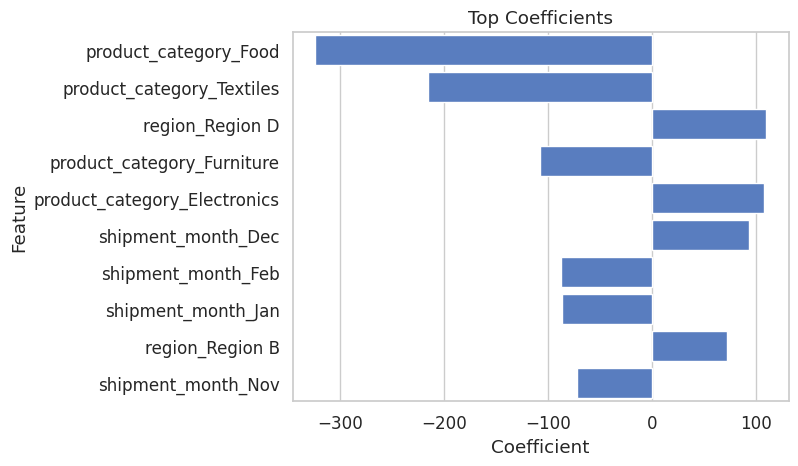

In [10]:
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature')
plt.title('Top Coefficients')
plt.show()

## Ridge Regression with Cross-Validation

In [11]:
from sklearn.linear_model import RidgeCV, LassoCV

# Use the same preprocessing pipeline
alphas = np.logspace(-3, 3, 50)

# Ridge Regression with CV
ridge = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RidgeCV(alphas=alphas, cv=5))
])
ridge.fit(X_train, y_train)
print(f"Best Ridge alpha: {ridge.named_steps['regressor'].alpha_}")
print(f"Ridge R² score: {ridge.score(X_test, y_test):.4f}")
print(f"Ridge RMSE: {root_mean_squared_error(y_test, ridge.predict(X_test)):.2f}")

Best Ridge alpha: 0.49417133613238334
Ridge R² score: 0.9008
Ridge RMSE: 57.35


## Lasso Regression with Cross-Validation

In [12]:
lasso = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LassoCV(alphas=alphas, cv=5, max_iter=1000))
])

lasso.fit(X_train, y_train)
print(f"Best Lasso alpha: {lasso.named_steps['regressor'].alpha_}")
print(f"Lasso R² score: {lasso.score(X_test, y_test):.4f}")
print(f"Lasso RMSE: {root_mean_squared_error(y_test, lasso.predict(X_test)):.2f}")

Best Lasso alpha: 0.005428675439323859
Lasso R² score: 0.9008
Lasso RMSE: 57.35


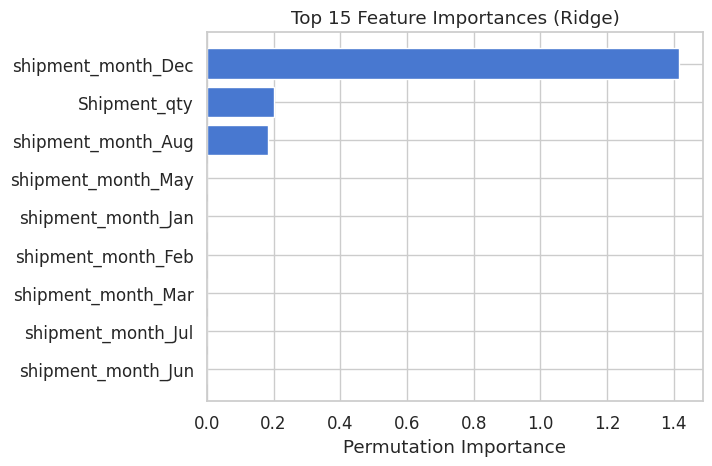

In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(ridge, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

# Get feature names after preprocessing
encoded_features = model.named_steps['preprocess'].transformers_[1][1].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(encoded_features)

# Plot top features
import matplotlib.pyplot as plt

plt.barh(np.array(feature_names)[sorted_idx[:15]], result.importances_mean[sorted_idx[:15]])
plt.xlabel("Permutation Importance")
plt.title("Top 15 Feature Importances (Ridge)")
plt.gca().invert_yaxis()
plt.show()


## XGBoost with Preprocessing and GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# XGBoost model (note: set verbosity=0 to keep output clean)
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

#### Define hyperparameter grid

In [15]:
# Define hyperparameter grid
param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

#### Grid Search with 5-fold CV

In [16]:
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"XGBoost R² on test set: {grid_search.score(X_test, y_test):.4f}")
print(f"XGBoost RMSE on test set: {root_mean_squared_error(y_test, grid_search.predict(X_test)):.2f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}
XGBoost R² on test set: 0.9090
XGBoost RMSE on test set: 54.94
